In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [61]:
PATH = "/D/MIT-WHOI/github_repos/syn_model/data/dfmerged_dailysynenv.csv"

df = pd.read_csv(PATH)

df["date"] = pd.to_datetime(df["date"],format = "%Y-%m-%d")

df.head()


,date,AvgSolar,AvgWindDir,AvgWindSpeed,Beam_temperature_corrected,NH4_mean,NO3_mean,PO4_mean,SiO2_mean,doy,doy_numeric,month,monthname,synconc,year
0,2003-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-10,130,5.0,May,354.187094,2003
1,2003-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-11,131,5.0,May,381.916883,2003
2,2003-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-12,132,5.0,May,507.483356,2003
3,2003-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-13,133,5.0,May,704.463939,2003
4,2003-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-14,134,5.0,May,898.691727,2003


In [62]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AvgSolar,3074.0,149.891778,94.450048,-2.800000,74.079861,132.141071,228.845833,851.388235
AvgWindDir,3074.0,198.149130,72.314866,13.912500,150.370833,210.491024,252.054167,340.055556
AvgWindSpeed,3074.0,5.216600,2.309749,0.729167,3.635764,4.793056,6.316319,25.530556
Beam_temperature_corrected,3074.0,10.641422,6.403568,-1.419508,4.714215,10.633121,16.645245,21.855795
NH4_mean,3.0,0.579822,0.213064,0.336760,0.502571,0.668381,0.701353,0.734325
NO3_mean,3.0,0.316256,0.463775,0.041841,0.048523,0.055206,0.453464,0.851722
PO4_mean,3.0,0.272177,0.356990,0.052669,0.066217,0.079765,0.381931,0.684097
SiO2_mean,3.0,1.316951,0.228844,1.138648,1.187928,1.237208,1.406103,1.574998
doy_numeric,4743.0,187.127556,101.736581,1.000000,105.500000,187.000000,274.000000,366.000000
synconc,4009.0,41327.461515,49862.007112,50.135234,2137.894054,20648.136931,64926.988420,323472.170691


In [63]:
 dftemp_syn = df[["date","Beam_temperature_corrected","synconc"]].dropna()

Text(0, 0.5, 'Syn Concentration')

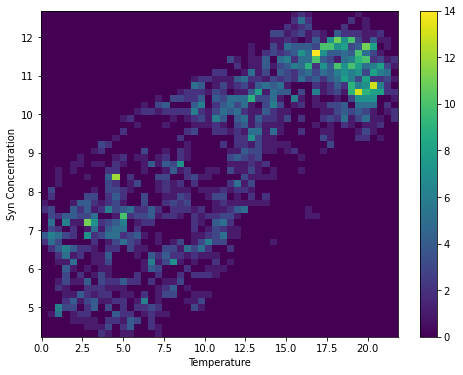

In [64]:
plt.hist2d(dftemp_syn.Beam_temperature_corrected, np.log(dftemp_syn.synconc), bins = (50,50))
plt.colorbar()
plt.xlabel('Temperature')
plt.ylabel('Syn Concentration')

Text(0.5, 1.0, 'Wind Direction vs. Wind Velocity')

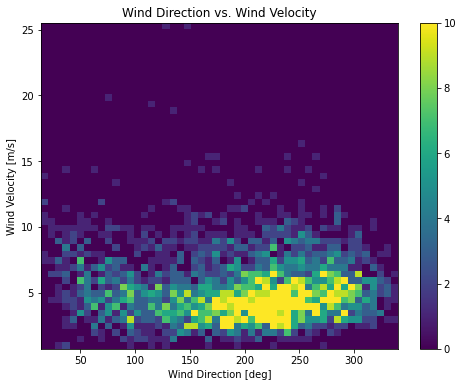

In [65]:
plt.hist2d(df['AvgWindDir'].dropna(), df['AvgWindSpeed'].dropna(), bins=(50, 50), vmax=10)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.title("Wind Direction vs. Wind Velocity")

In [66]:
wv = df['AvgWindSpeed']
# Convert to radians.
wd_rad = df['AvgWindDir']*np.pi / 180
# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

Text(0.5, 1.0, 'Wind X Vector vs. Wind Y Vector')

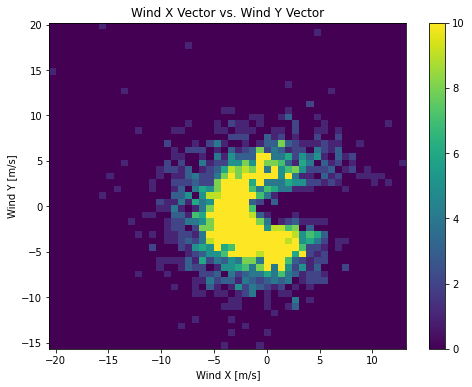

In [67]:
plt.hist2d(df['Wx'].dropna(), df['Wy'].dropna(), bins=(50, 50), vmax=10)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.title("Wind X Vector vs. Wind Y Vector")

In [68]:
timestamp_s = df["date"].map(pd.Timestamp.timestamp)
timestamp_s
day = 24*60*60
year = (365.2425)*day

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Year')

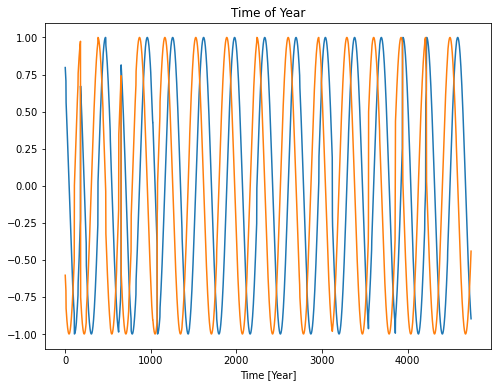

In [69]:
plt.plot(np.array(df['Year sin']))
plt.plot(np.array(df['Year cos']))
plt.xlabel('Time [Year]')
plt.title('Time of Year')

## Finding Relevant Frequencies for Temperature

3074
8.416098018794674
[   0    1    2 ... 1535 1536 1537]


Text(0, 0.5, 'Number of Observations')

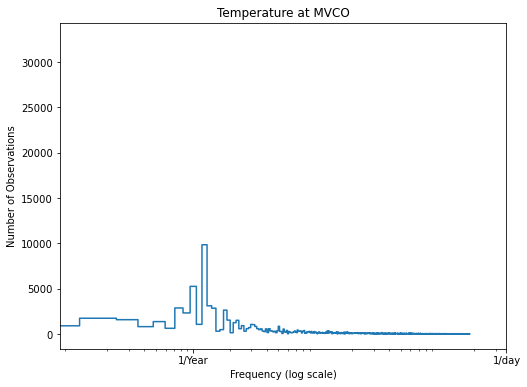

In [70]:
fft = tf.signal.rfft(df['Beam_temperature_corrected'].dropna())
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Beam_temperature_corrected'].dropna())
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

print(n_samples_d)
print(years_per_dataset)

print(f_per_dataset)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.title("Temperature at MVCO")
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.ylabel("Number of Observations")

4009
10.975971684238077
[   0    1    2 ... 2002 2003 2004]


Text(0, 0.5, 'Number of Observations')

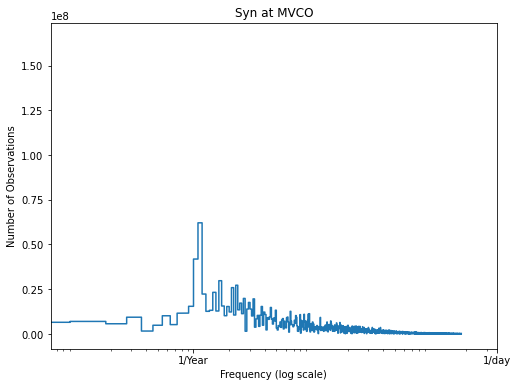

In [71]:
fft = tf.signal.rfft(df['synconc'].dropna())
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['synconc'].dropna())
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

print(n_samples_d)
print(years_per_dataset)

print(f_per_dataset)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.title("Syn at MVCO")
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.ylabel("Number of Observations")

3074
8.416098018794674
[   0    1    2 ... 1535 1536 1537]


Text(0, 0.5, 'Number of Observations')

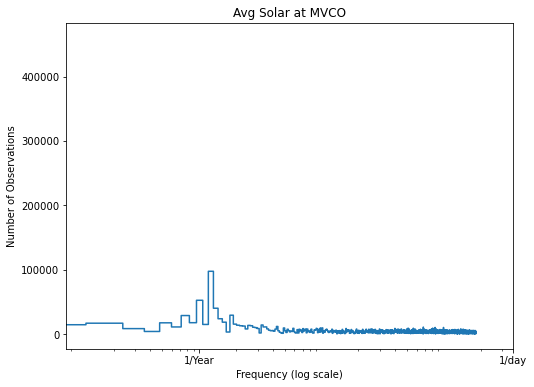

In [72]:
fft = tf.signal.rfft(df['AvgSolar'].dropna())
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['AvgSolar'].dropna())
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

print(n_samples_d)
print(years_per_dataset)

print(f_per_dataset)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.title("Avg Solar at MVCO")
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.ylabel("Number of Observations")

3074
8.416098018794674
[   0    1    2 ... 1535 1536 1537]


Text(0, 0.5, 'Number of Observations')

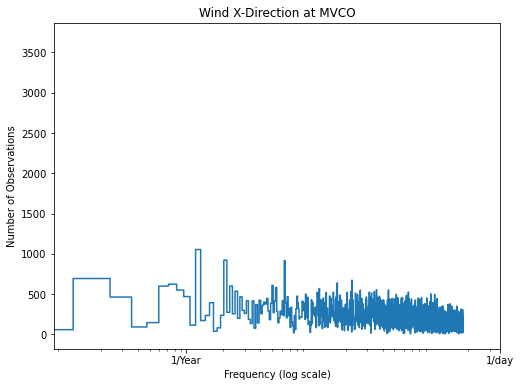

In [74]:
fft = tf.signal.rfft(df['Wy'].dropna())
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Wy'].dropna())
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

print(n_samples_d)
print(years_per_dataset)

print(f_per_dataset)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.title("Wind X-Direction at MVCO")
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.ylabel("Number of Observations")

Wind data doesn't really occur at a particular frequency.

### Splitting Data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [75]:
df.columns

Index(['date', 'AvgSolar', 'AvgWindDir', 'AvgWindSpeed',
       'Beam_temperature_corrected', 'NH4_mean', 'NO3_mean', 'PO4_mean',
       'SiO2_mean', 'doy', 'doy_numeric', 'month', 'monthname', 'synconc',
       'year', 'Wx', 'Wy', 'Year sin', 'Year cos'],
      dtype='object')

In [90]:
dftrain = df.loc[:, ~df.columns.isin(['date','doy','doy_numeric','month','monthname','year','NH4_mean','NO3_mean','PO4_mean','SiO2_mean',"AvgWindDir","AvgWindSpeed"])].dropna()

In [110]:
dftrain.reset_index()

,index,AvgSolar,Beam_temperature_corrected,synconc,Wx,Wy,Year sin,Year cos
0,288,250.390278,19.035505,80105.245532,1.013587,4.735803,-0.956660,-0.291209
1,289,155.976389,18.861665,101973.413791,-2.007394,3.119681,-0.961527,-0.274709
2,290,97.198611,18.879350,107654.955960,-4.228400,0.368698,-0.966111,-0.258128
3,291,124.245833,18.940860,94600.516929,-4.182438,-2.245737,-0.970408,-0.241471
4,292,32.712500,18.853337,69184.121285,-2.353142,7.971028,-0.974418,-0.224743
...,...,...,...,...,...,...,...,...
2335,4737,231.938028,20.040080,50096.251907,3.066648,5.130863,-0.856098,-0.516813
2336,4738,227.277778,20.129447,44982.359415,0.607287,4.053371,-0.864862,-0.502010
2337,4739,239.174648,20.329384,44796.886617,-1.666291,-2.243202,-0.873369,-0.487058
2338,4740,125.856338,20.993243,48695.576056,-3.114274,-3.476757,-0.881619,-0.471963


In [111]:
column_indices = {name: i for i, name in enumerate(dftrain.columns)}

n = len(dftrain.dropna())
train_df = dftrain.dropna()[0:int(n*0.7)]
val_df = dftrain.dropna()[int(n*0.7):int(n*0.9)]
test_df = dftrain.dropna()[int(n*0.9):]

num_features = dftrain.dropna().shape[1]

In [112]:
train_mean = train_df.mean()
train_std = train_df.std()

print(train_mean)
print(train_std)

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

AvgSolar                        150.322066
Beam_temperature_corrected       11.084326
synconc                       36521.254653
Wx                               -1.719321
Wy                               -1.072141
Year sin                          0.033573
Year cos                          0.032717
dtype: float64
AvgSolar                         91.423954
Beam_temperature_corrected        6.433346
synconc                       48433.018008
Wx                                3.357747
Wy                                4.342688
Year sin                          0.724568
Year cos                          0.688050
dtype: float64


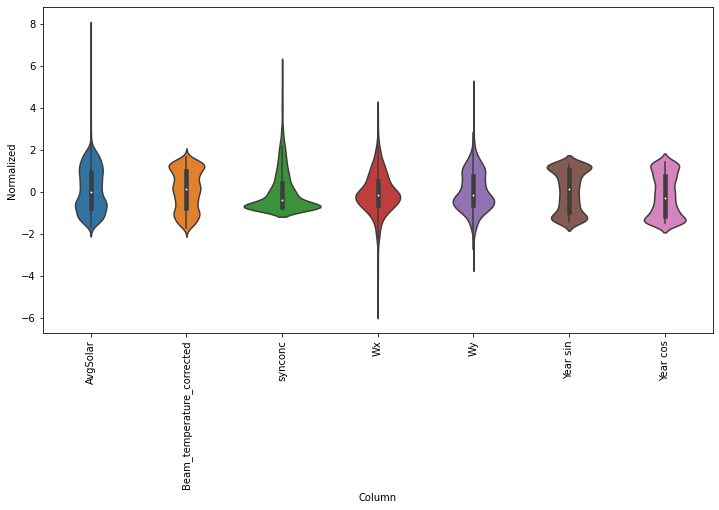

In [113]:
df_std = (dftrain - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dftrain.keys(), rotation=90)

In [114]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [115]:
w1 = WindowGenerator(input_width=365*6, label_width=1, shift=365,
                     label_columns=['Beam_temperature_corrected'])
w1

Total window size: 2555
Input indices: [   0    1    2 ... 2187 2188 2189]
Label indices: [2554]
Label column name(s): ['Beam_temperature_corrected']

In [116]:
w2 = WindowGenerator(input_width=365*5, label_width=1, shift=1,
                     label_columns=['Beam_temperature_corrected'])
w2

Total window size: 1826
Input indices: [   0    1    2 ... 1822 1823 1824]
Label indices: [1825]
Label column name(s): ['Beam_temperature_corrected']

In [117]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [119]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [1638,7] != values[1].shape = [1538,7] [Op:Pack] name: stack

In [197]:
w2.example = example_inputs, example_labels

AttributeError: can't set attribute

In [164]:
def plot(self, model=None, plot_col='Beam_temperature_corrected', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

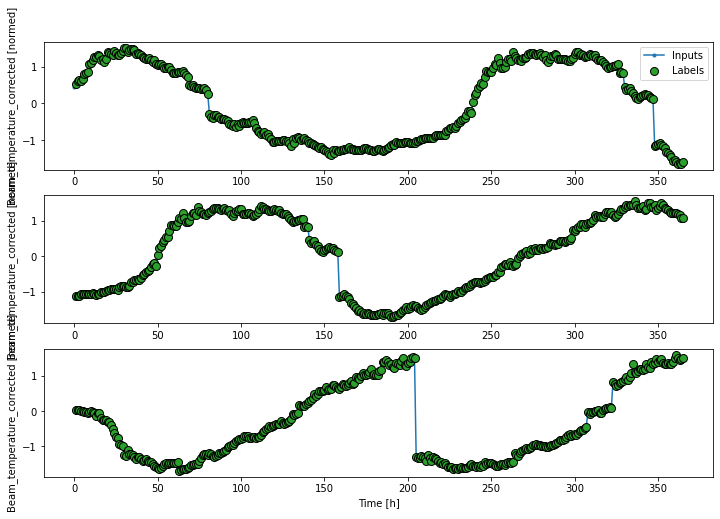

In [165]:
w2.plot()

In [166]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [167]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [168]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 365, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 365, 1), dtype=tf.float32, name=None))

In [169]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Beam_temperature_corrected'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Beam_temperature_corrected']

In [170]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 365, 10)
Labels shape (batch, time, features): (32, 365, 1)


In [171]:
class Baseline(keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [172]:
baseline = Baseline(label_index=column_indices['Beam_temperature_corrected'])

baseline.compile(loss=keras.losses.MeanSquaredError(),
                 metrics=[keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

15/15 [==============================] - 0s 479us/step - loss: 0.0228 - mean_absolute_error: 0.0583


In [176]:
wide_window = WindowGenerator(
    input_width=365, label_width=365, shift=1,
    label_columns=['Beam_temperature_corrected'])

wide_window

Total window size: 366
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [177]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 365, 10)
Output shape: (32, 365, 1)


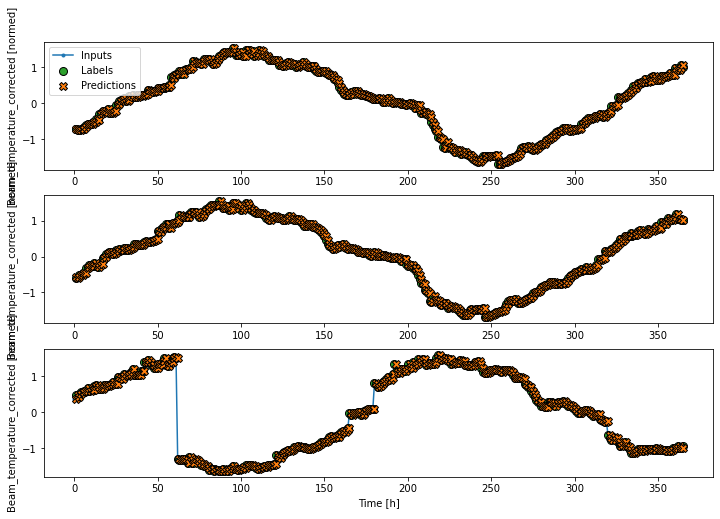

In [178]:
wide_window.plot(baseline)

# LINEAR MODEL

In [182]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [183]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


In [142]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.Adam(),
                metrics=[keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [143]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
15/15 [==============================] - 0s 525us/step - loss: nan - mean_absolute_error: nan


In [184]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 365, 10)
Output shape: (32, 365, 1)


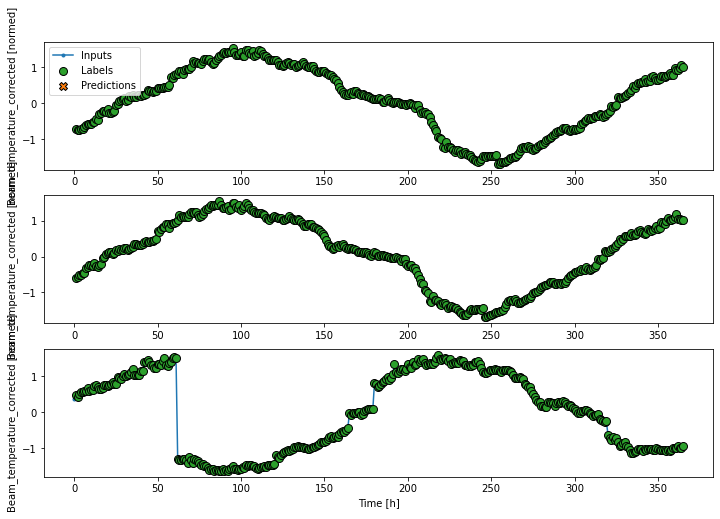

In [185]:
wide_window.plot(linear)

# LTSM Model

In [179]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [180]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 365, 10)
Output shape: (32, 365, 1)


In [181]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 1s 76ms/step - loss: nan - mean_absolute_error: nan


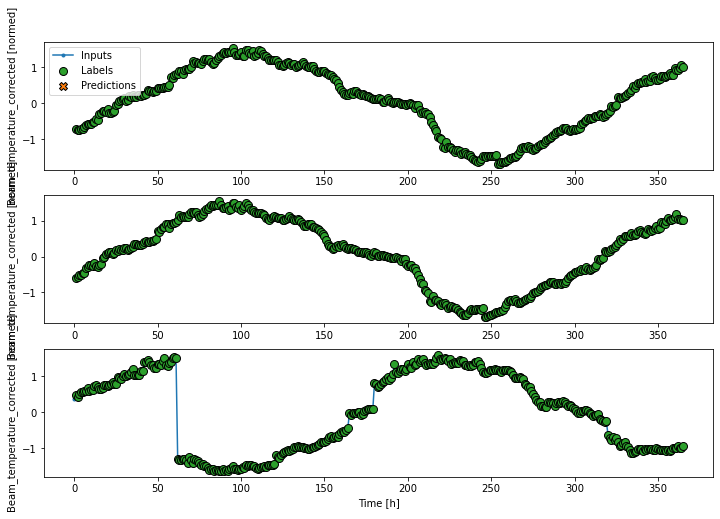

In [186]:
wide_window.plot(lstm_model)

In [187]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

IndexError: list index out of range